<a href="https://colab.research.google.com/github/Arya-86/ML_stacked_models/blob/main/Arya_kaggle_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Protein Expression Profiles in Single-Cell Sequencing Data Using Machine Learning Algorithms.

Arya Jadhav, Eva R. Pandey, and Jude Nogotey

#Introduction

This project tackles a cutting-edge biological challenge using CITE-seq, an innovative single-cell sequencing technology. CITE-seq allows for simultaneous measurement of gene and cell-surface protein expressions within individual cells, positioning it at the forefront of multi-modal analysis. This dual measurement capability offers a comprehensive view of the relationships between specific protein markers—key indicators of cell types—and transcriptional activities. Such insights enhance our understanding of complex cellular functions.

Our objective was to predict the protein expression profiles of 25 specific proteins in 1000 test cells, using gene expression data from 639 genes. The training dataset includes data from 4000 cells, providing complete profiles for both proteins and genes. The challenge goes beyond accurate prediction; it aims to deepen our understanding of the biological interplay between gene expression and protein presence.

We employed a range of machine learning models and techniques, including Adam, AdamW, and PCA. Advanced hyperparameter tuning and regularization were key components of our approach. Additionally, we utilized ensemble methods, integrating stacked models with meta-models like Random Forest and XGBoost to enhance the accuracy of our predictions.

# **Approach**

## Data pre-processing

We used PCA to reduce the dimensionality of the data and also used RobustScaler for standardizing the data. For regularization we used elastic net regularization by using L1 and L2.

## Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.4 MB/s eta 0:00:00


You would need to load your own dataset

In [ ]:
# Load the data
training_rna = pd.read_csv("/content/drive/MyDrive/CIS_678/Challenge_02/training_set_rna.csv", index_col=0).T
training_adt = pd.read_csv("/content/drive/MyDrive/CIS_678/Challenge_02/training_set_adt.csv", index_col=0).T
new_data_rna = pd.read_csv("/content/drive/MyDrive/CIS_678/Challenge_02/test_set_rna.csv", index_col=0).T

In [ ]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(training_rna, training_adt, test_size=0.3, random_state=123)

##Defining Functions

Function for training the model:

In [ ]:
#!pip install tensorflow
import tensorflow as tf
#!pip install tensorflow_addons
import tensorflow_addons as tfa
#from kerastuner import HyperModel
from tensorflow.keras import regularizers
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a schedule function that takes an epoch index (integer, indexed from 0) and current learning rate
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Add the LearningRateScheduler callback to the list of callbacks
def train_model(x_train, y_train, x_val, y_val, model, n_components=None, n_epochs=100, batch_size=32, seed=None):
    if seed:
        tf.random.set_seed(seed)

    scaler = RobustScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_val_scaled = scaler.transform(x_val)

    if n_components:
        pca = PCA(n_components=n_components)
        x_train_scaled = pca.fit_transform(x_train_scaled)
        x_val_scaled = pca.transform(x_val_scaled)

    # Include the LearningRateScheduler in the callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        LearningRateScheduler(scheduler)
    ]

    history = model.fit(x_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                        validation_data=(x_val_scaled, y_val), callbacks=callbacks)

    val_loss = model.evaluate(x_val_scaled, y_val)
    print("Validation Loss:", val_loss)

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

##Algorithm

The best approach that worked for us was that of using a stacking method, where we trained 5 different models using varied optimizers and acitvation functions. At the end, we trained a Random Forest meta-model that trained on the predictons of the base models, learning from their features and thus making it a robust and generalizable model.

###Model 1 - AdamW

 By incorporating weight decay directly into the optimization process, AdamW provides regularization, which is crucial for preventing the model from memorizing the training data and instead encourages it to learn meaningful patterns. This is particularly important for datasets like these, where there may be complex relationships between features and targets and a risk of overfitting due to high dimensionality. Overall, AdamW helps ensure more stable and efficient optimization, leading to better performance on unseen data.

In [ ]:
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow_addons as tfa
from sklearn.decomposition import PCA
from tensorflow.keras.regularizers import l1_l2

scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)  # Use the same scaler to ensure consistency



pca = PCA(n_components=0.70)  # Retaining 70% of variance
X_pca = pca.fit_transform(x_train_scaled)
# X_val_pca = pca.transform(x_val_scaled)  # Transform the validation RNA data with the trained PCA

n_features = X_pca.shape[1]

# Define your l1 and l2 regularization factors
l1_factor = 1e-5  # Example value, should be tuned
l2_factor = 1e-4  # Example value, should be tuned

model1 = Sequential([
    Dense(70, activation='sigmoid', input_shape=(n_features,), kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
    Dropout(0.25),
    Dense(50, activation='mish', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
    Dense(25, activation='linear', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))
])

# Adjust the learning rate to a new value, for example, increasing it to 1e-3
new_learning_rate = 0.001  # A larger learning rate

model1.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=new_learning_rate, weight_decay=1e-5),
    loss='mean_squared_error'
)

Epoch 1/500
56/56 [==============================] - 1s 6ms/step - loss: 0.7626 - val_loss: 0.4263 - lr: 0.0010
Epoch 2/500
56/56 [==============================] - 0s 4ms/step - loss: 0.4267 - val_loss: 0.3214 - lr: 0.0010
Epoch 3/500
56/56 [==============================] - 0s 3ms/step - loss: 0.3440 - val_loss: 0.2769 - lr: 0.0010
Epoch 4/500
56/56 [==============================] - 0s 4ms/step - loss: 0.3067 - val_loss: 0.2489 - lr: 0.0010
Epoch 5/500
56/56 [==============================] - 0s 4ms/step - loss: 0.2779 - val_loss: 0.2307 - lr: 0.0010
Epoch 6/500
56/56 [==============================] - 0s 3ms/step - loss: 0.2573 - val_loss: 0.2155 - lr: 0.0010
Epoch 7/500
56/56 [==============================] - 0s 4ms/step - loss: 0.2412 - val_loss: 0.2063 - lr: 0.0010
Epoch 8/500
56/56 [==============================] - 0s 3ms/step - loss: 0.2305 - val_loss: 0.2022 - lr: 0.0010
Epoch 9/500
56/56 [==============================] - 0s 4ms/step - loss: 0.2210 - val_loss: 0.1957 - lr:

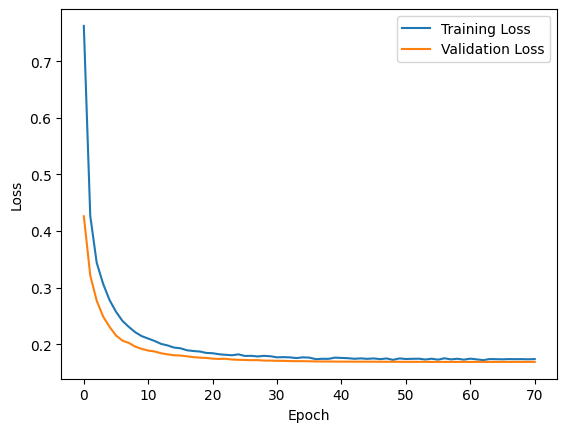

In [ ]:
train_model(x_train, y_train, x_val, y_val, model=model1, n_components=0.70, n_epochs=500, batch_size=50)

###Model 2 - Adadelta

Adadelta might be a good choice for this dataset because it is designed to address the diminishing learning rates of Adagrad. It adapts the learning rates based on a window of gradient updates, rather than accumulating all past gradients, which helps in avoiding a too aggressive decrease in learning rates. This could be particularly beneficial if the dataset has complex or non-stationary features, as Adadelta could potentially provide more robust updates and convergence.

In [ ]:

from tensorflow.keras.optimizers import Adadelta

# Define your custom learning rate and rho
custom_lr = 0.99 # Starting with a higher learning rate
custom_rho = 0.90  # Keeping the default rho value

# Define your l1 and l2 regularization factors
l1_factor = 0.001  # This is a common starting value for L1 regularization
l2_factor = 0.001  # This is a common starting value for L2 regularization

model2 = Sequential([
    Dense(70, activation='relu', input_shape=(X_pca.shape[1],), kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
    Dropout(0.25),
    Dense(50, activation='LeakyReLU', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
    Dense(25, activation='linear', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))
])

model2.compile(optimizer=Adadelta(learning_rate=custom_lr, rho=custom_rho),
               loss='mean_squared_error')

# history = model2.fit(X_pca, y_train, epochs=100, batch_size=32, validation_data=(X_val_pca, y_val))
# val_loss = model2.evaluate(X_val_pca, y_val)
# print("Validation Loss:", val_loss)
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

Epoch 1/500
56/56 [==============================] - 1s 6ms/step - loss: 2.8252 - val_loss: 2.0583 - lr: 0.9900
Epoch 2/500
56/56 [==============================] - 0s 4ms/step - loss: 1.9475 - val_loss: 1.6484 - lr: 0.9900
Epoch 3/500
56/56 [==============================] - 0s 4ms/step - loss: 1.5331 - val_loss: 1.3011 - lr: 0.9900
Epoch 4/500
56/56 [==============================] - 0s 4ms/step - loss: 1.1771 - val_loss: 0.9820 - lr: 0.9900
Epoch 5/500
56/56 [==============================] - 0s 4ms/step - loss: 0.8724 - val_loss: 0.7248 - lr: 0.9900
Epoch 6/500
56/56 [==============================] - 0s 4ms/step - loss: 0.6493 - val_loss: 0.5497 - lr: 0.9900
Epoch 7/500
56/56 [==============================] - 0s 4ms/step - loss: 0.5107 - val_loss: 0.4508 - lr: 0.9900
Epoch 8/500
56/56 [==============================] - 0s 4ms/step - loss: 0.4322 - val_loss: 0.3952 - lr: 0.9900
Epoch 9/500
56/56 [==============================] - 0s 4ms/step - loss: 0.3904 - val_loss: 0.3634 - lr:

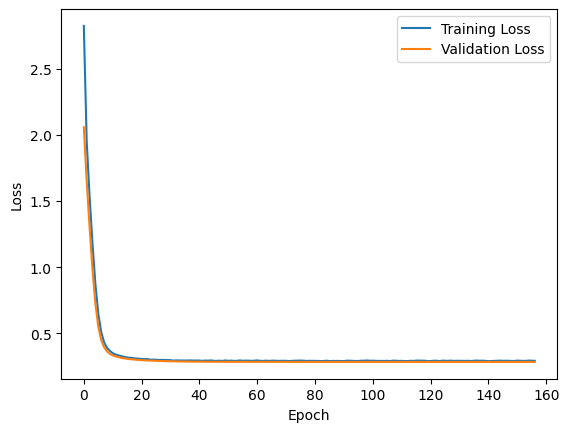

In [ ]:
train_model(x_train, y_train, x_val, y_val, model=model2, n_components=0.70, n_epochs=500, batch_size=50)

###Model 3 - Adamax

Adamax may be an appropriate optimizer for this dataset because it's an adaptation of Adam that performs well across a wide range of tasks. It can be particularly useful if the data or gradients are sparse as it uses the infinity norm for parameter updates, which might help in cases where the gradients have large variances or are unstable. Additionally, Adamax could be more robust to the choice of hyperparameters, especially the learning rate, making it a good choice for a dataset with complex patterns where setting the perfect learning rate is challenging.

In [ ]:
from tensorflow.keras.optimizers import Adamax

# Define your l1 and l2 regularization factors
l1_factor = 0.0001  # This is a common starting value for L1 regularization
l2_factor = 0.0001  # This is a common starting value for L2 regularization

model3 = Sequential([
    Dense(80, activation='sigmoid', input_shape=(X_pca.shape[1],), kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
    Dropout(0.25),
    Dense(50, activation='LeakyReLU', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
    Dense(25, activation='linear', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))
])

# For Adamax
# Define your custom learning rate and decay rates
custom_lr = 1e-2  # or 1e-5 based on the above considerations
beta_1 = 0.92  # Default value, but you might want to try values closer to 1
beta_2 = 0.90  # Default value, or you might want to reduce it slightly

model3.compile(optimizer=Adamax(learning_rate=custom_lr, beta_1=beta_1, beta_2=beta_2),
               loss='mean_squared_error')


Epoch 1/500
56/56 [==============================] - 2s 9ms/step - loss: 0.5262 - val_loss: 0.3174 - lr: 0.0100
Epoch 2/500
56/56 [==============================] - 0s 5ms/step - loss: 0.3008 - val_loss: 0.2599 - lr: 0.0100
Epoch 3/500
56/56 [==============================] - 0s 5ms/step - loss: 0.2639 - val_loss: 0.2413 - lr: 0.0100
Epoch 4/500
56/56 [==============================] - 0s 5ms/step - loss: 0.2482 - val_loss: 0.2278 - lr: 0.0100
Epoch 5/500
56/56 [==============================] - 0s 6ms/step - loss: 0.2386 - val_loss: 0.2239 - lr: 0.0100
Epoch 6/500
56/56 [==============================] - 0s 5ms/step - loss: 0.2345 - val_loss: 0.2229 - lr: 0.0100
Epoch 7/500
56/56 [==============================] - 0s 5ms/step - loss: 0.2334 - val_loss: 0.2172 - lr: 0.0100
Epoch 8/500
56/56 [==============================] - 0s 4ms/step - loss: 0.2280 - val_loss: 0.2206 - lr: 0.0100
Epoch 9/500
56/56 [==============================] - 0s 4ms/step - loss: 0.2275 - val_loss: 0.2136 - lr:

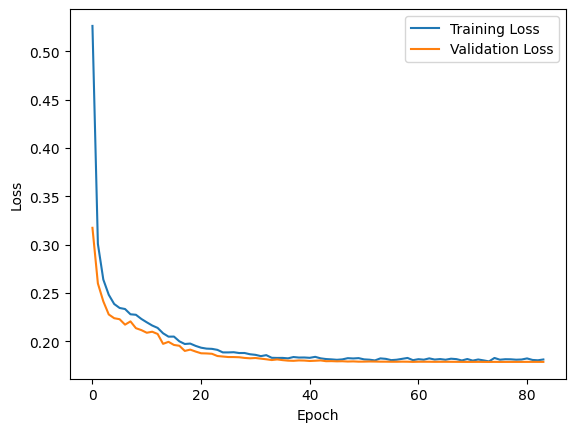

In [ ]:
train_model(x_train, y_train, x_val, y_val, model=model3, n_components=0.70, n_epochs=500, batch_size=50)

###Model 4 - SGD

In [ ]:
from tensorflow.keras.optimizers import SGD
# Define your l1 and l2 regularization factors
l1_factor = 0.001  # Example value, should be tuned
l2_factor = 0.001  # Example value, should be tuned

model4 = Sequential([
    Dense(80, activation='LeakyReLU', input_shape=(X_pca.shape[1],), kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
    Dropout(0.30),
    Dense(50, activation='LeakyReLU', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
    Dense(25, activation='linear', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))
])

# Try a higher learning rate
model4.compile(optimizer=SGD(learning_rate=0.3, momentum=0.9),
               loss='mean_squared_error')

Epoch 1/500
51/51 [==============================] - 1s 8ms/step - loss: 1.4519 - val_loss: 0.5366 - lr: 0.3000
Epoch 2/500
51/51 [==============================] - 0s 5ms/step - loss: 0.3959 - val_loss: 0.3268 - lr: 0.3000
Epoch 3/500
51/51 [==============================] - 0s 4ms/step - loss: 0.3253 - val_loss: 0.3040 - lr: 0.3000
Epoch 4/500
51/51 [==============================] - 0s 4ms/step - loss: 0.3169 - val_loss: 0.3011 - lr: 0.3000
Epoch 5/500
51/51 [==============================] - 0s 4ms/step - loss: 0.3143 - val_loss: 0.3001 - lr: 0.3000
Epoch 6/500
51/51 [==============================] - 0s 5ms/step - loss: 0.3112 - val_loss: 0.2945 - lr: 0.3000
Epoch 7/500
51/51 [==============================] - 0s 5ms/step - loss: 0.3147 - val_loss: 0.2999 - lr: 0.3000
Epoch 8/500
51/51 [==============================] - 0s 4ms/step - loss: 0.3096 - val_loss: 0.3053 - lr: 0.3000
Epoch 9/500
51/51 [==============================] - 0s 6ms/step - loss: 0.3095 - val_loss: 0.3018 - lr:

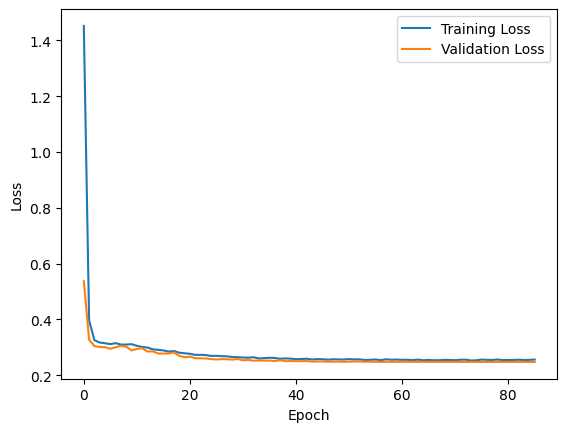

In [ ]:
train_model(x_train, y_train, x_val, y_val, model=model4, n_components=0.70, n_epochs=500, batch_size=55)

### Model 5 - RMSProp

In [ ]:
from tensorflow.keras.optimizers import RMSprop
# Define your l1 and l2 regularization factors
l1_factor = 0.0001  # This is a common starting value for L1 regularization
l2_factor = 0.0001  # This is a common starting value for L2 regularization

model5 = Sequential([
    Dense(80, activation='LeakyReLU', input_shape=(X_pca.shape[1],), kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
    Dropout(0.25),
    Dense(50, activation='elu', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
    Dense(25, activation='linear', kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor))
])

# Configuring RMSprop optimizer
model5.compile(optimizer=RMSprop(learning_rate=0.001),  # RMSprop's default learning rate is a good starting point
               loss='mean_squared_error')



Epoch 1/300
44/44 [==============================] - 2s 11ms/step - loss: 1.2344 - val_loss: 0.5837 - lr: 0.0010
Epoch 2/300
44/44 [==============================] - 0s 6ms/step - loss: 0.6300 - val_loss: 0.4350 - lr: 0.0010
Epoch 3/300
44/44 [==============================] - 0s 6ms/step - loss: 0.4691 - val_loss: 0.3715 - lr: 0.0010
Epoch 4/300
44/44 [==============================] - 0s 7ms/step - loss: 0.3927 - val_loss: 0.3369 - lr: 0.0010
Epoch 5/300
44/44 [==============================] - 0s 7ms/step - loss: 0.3500 - val_loss: 0.3130 - lr: 0.0010
Epoch 6/300
44/44 [==============================] - 0s 5ms/step - loss: 0.3214 - val_loss: 0.2960 - lr: 0.0010
Epoch 7/300
44/44 [==============================] - 0s 5ms/step - loss: 0.2998 - val_loss: 0.2807 - lr: 0.0010
Epoch 8/300
44/44 [==============================] - 0s 4ms/step - loss: 0.2826 - val_loss: 0.2698 - lr: 0.0010
Epoch 9/300
44/44 [==============================] - 0s 4ms/step - loss: 0.2690 - val_loss: 0.2588 - lr

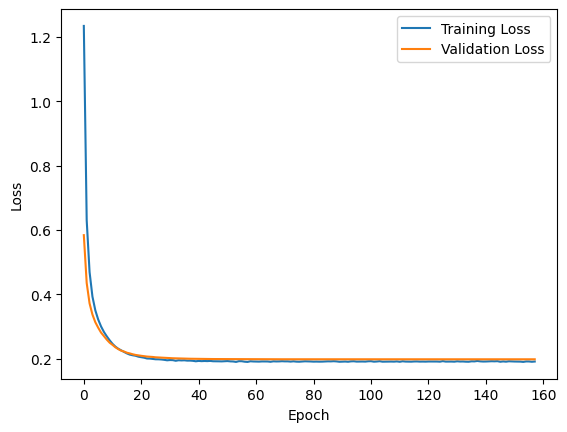

In [ ]:
train_model(x_train, y_train, x_val, y_val, model=model5, n_components=0.70, n_epochs=300, batch_size=64)

### Meta-model Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Scale the new RNA data
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
pca = PCA(n_components=0.70)  # Retaining 70% of variance
X_pca = pca.fit_transform(x_train_scaled)
X_val_pca = pca.transform(x_val_scaled)  # Transform the validation RNA data with the trained PCA
new_data_rna_scaled = scaler.transform(new_data_rna)

# Apply PCA transformation to the new RNA data
new_data_rna_pca = pca.transform(new_data_rna_scaled)


# Let's assume you've trained several models and stored them in a list
base_models = [model1, model2, model3, model4, model5]  # model1, model2, model3 are your trained base models

# Collect the predictions from each model
stacked_features = np.column_stack([
    model.predict(X_val_pca) for model in base_models
])

# Train a meta-model on these features
meta_model = RandomForestRegressor(n_estimators=200, random_state=42).fit(stacked_features, y_val)

# When making final predictions, collect the base model predictions on the test set
# and use the meta-model to make the final prediction
stacked_test_features = np.column_stack([
    model.predict(new_data_rna_pca) for model in base_models
])
final_predictions = meta_model.predict(stacked_test_features)

# Flatten the predictions and prepare for submission as before
flattened_predictions = final_predictions.flatten()

# Convert the flattened array to a pandas DataFrame
predicted_adt_df = pd.DataFrame(flattened_predictions, columns=['Expected'])

# Create an ID column based on the row number
predicted_adt_df['ID'] = ['ID_' + str(i + 1) for i in range(len(predicted_adt_df))]

# Reorder the columns to match the required submission format
predicted_adt_df = predicted_adt_df[['ID', 'Expected']]


32/32 [==============================] - 0s 1ms/step


In [ ]:
submission_file_path = '/content/drive/MyDrive/CIS_678/Challenge_02/nn_meta-randomF__robRMS_lrschedLR_sunday_submission.csv'
predicted_adt_df.to_csv(submission_file_path, index=False)

## Trying to find the best Hyperparameter

We experimented with various functions to find the best hyperparameter for the models, however, they did not yield any satisfactory results.

###Define the model in a function

In [ ]:
!pip install keras-tuner
import tensorflow as tf
import tensorflow_addons as tfa
from kerastuner import HyperModel

class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(
                units=hp.Int('units', min_value=32, max_value=512, step=32),
                activation='relu',
                input_shape=(self.input_shape,)
            ),
            tf.keras.layers.Dense(25)  # Assuming 25 proteins to predict
        ])

        model.compile(
            optimizer=tfa.optimizers.AdamW(
                learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'),
                weight_decay=hp.Float('weight_decay', min_value=1e-5, max_value=1e-3, sampling='log')
            ),
            loss='mean_squared_error'
        )
        return model


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 902.0 kB/s eta 0:00:00


<ipython-input-40-d64f3be31bd0>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


Run hyperparameter search

In [ ]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    MyHyperModel(input_shape=x_train.shape[1]),
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='adamw_tuning'
)

tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


Trial 20 Complete [00h 00m 05s]
val_loss: 0.5756759643554688

Best val_loss So Far: 0.45787790417671204
Total elapsed time: 00h 02m 14s


Get the best model:

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

However, this model did not outperform the AdamW with default settings

##Further hypertuning with l2 Regularization

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from kerastuner import HyperModel
from tensorflow.keras import regularizers
from kerastuner import HyperModel

class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = tf.keras.Sequential()
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(tf.keras.layers.Dense(
                units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                activation='relu',
                kernel_regularizer=regularizers.l2(hp.Float('l2_' + str(i), min_value=1e-5, max_value=1e-2, sampling='log')),
                input_shape=(self.input_shape if i == 0 else None,)
            ))
        model.add(tf.keras.layers.Dense(25))  # Assuming 25 proteins to predict

        model.compile(
            optimizer=tfa.optimizers.AdamW(
                learning_rate=hp.Float('learning_rate', min_value=5e-5, max_value=5e-4, sampling='log'),
                weight_decay=hp.Float('weight_decay', min_value=1e-5, max_value=1e-4, sampling='log')
            ),
            loss='mean_squared_error'
        )
        return model


In [ ]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    MyHyperModel(input_shape=x_train.shape[1]),
    objective='val_loss',
    max_trials=35,  # Adjust based on computational budget
    executions_per_trial=1,
    directory='my_dir',
    project_name='adamw_tuning_refined'
)

tuner.search(x_train, y_train, epochs=60, validation_data=(x_val, y_val))


Trial 35 Complete [00h 00m 25s]
val_loss: 0.5330778956413269

Best val_loss So Far: 0.46352025866508484
Total elapsed time: 00h 18m 57s


Get the best hyperparameters

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters_values = best_hyperparameters.values

In [ ]:
print(best_hyperparameters_values)

{'num_layers': 2, 'units_0': 32, 'l2_0': 1.8240387446140548e-05, 'learning_rate': 6.844568764003267e-05, 'weight_decay': 1.8242991031363712e-05, 'units_1': 224, 'l2_1': 0.00015493743411506213, 'units_2': 352, 'l2_2': 1.6522275610856798e-05}


Build the model using the best hyperparameters:

In [ ]:
best_model = MyHyperModel(input_shape=x_train.shape[1]).build(best_hyperparameters)

best_model.fit(x_train, y_train, epochs=60, validation_data=(x_val, y_val))

Epoch 1/60


88/88 [==============================] - 1s 5ms/step - loss: 0.8650 - val_loss: 0.5860
Epoch 2/60
88/88 [==============================] - 0s 4ms/step - loss: 0.5590 - val_loss: 0.5352
Epoch 3/60
88/88 [==============================] - 0s 4ms/step - loss: 0.5298 - val_loss: 0.5166
Epoch 4/60
88/88 [==============================] - 0s 3ms/step - loss: 0.5134 - val_loss: 0.5037
Epoch 5/60
88/88 [==============================] - 0s 3ms/step - loss: 0.5031 - val_loss: 0.4958
Epoch 6/60
88/88 [==============================] - 0s 4ms/step - loss: 0.4955 - val_loss: 0.4898
Epoch 7/60
88/88 [==============================] - 0s 4ms/step - loss: 0.4897 - val_loss: 0.4858
Epoch 8/60
88/88 [==============================] - 0s 4ms/step - loss: 0.4856 - val_loss: 0.4824
Epoch 9/60
88/88 [==============================] - 0s 4ms/step - loss: 0.4820 - val_loss: 0.4793
Epoch 10/60
88/88 [==============================] - 0s 4ms/step - loss: 0.4794 - val_loss: 0.4767
Epoch 11/60
88/88 [===========

In [ ]:
predicted_adt_adw = best_model.predict(new_data_rna)


32/32 [==============================] - 0s 1ms/step


In [ ]:
# Flatten the predictions
flattened_predictions = predicted_adt_adw.flatten()

# Convert the flattened array to a pandas DataFrame
predicted_adt_df = pd.DataFrame(flattened_predictions, columns=['Expected'])

# Create an ID column based on the row number
predicted_adt_df['ID'] = ['ID_' + str(i + 1) for i in range(len(predicted_adt_df))]

# Reorder the columns to match the required submission format
predicted_adt_df = predicted_adt_df[['ID', 'Expected']]

In [ ]:
submission_file_path = '/content/drive/MyDrive/CIS_678/Challenge_02/nn_adwTuned_submission.csv'
predicted_adt_df.to_csv(submission_file_path, index=False)

## Meta model hypertuned XGB

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from xgboost import XGBRegressor
# Define the parameter distributions for randomized search
param_distributions = {
    'n_estimators': stats.randint(50, 151),
    'max_depth': stats.randint(3, 8),
    'learning_rate': stats.uniform(0.01, 0.29),
    'min_child_weight': stats.randint(1, 6),
    'subsample': stats.uniform(0.5, 0.4),
    'colsample_bytree': stats.uniform(0.5, 0.4),
    'gamma': stats.uniform(0, 0.2),
    'reg_alpha': stats.uniform(0, 0.5),
    'reg_lambda': stats.uniform(1, 1)
}

# Initialize XGBoost regressor
xgb_model = XGBRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions,
                                   n_iter=100, cv=3, scoring='neg_mean_squared_error', random_state=42)

# Fit RandomizedSearchCV to the data
random_search.fit(stacked_features, y_val)

# Get the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final XGBoost model with the best parameters
final_xgb_model = XGBRegressor(**best_params, random_state=42)
final_xgb_model.fit(stacked_features, y_val)


# Results

After submitting our predicted values for the Test ADT to Kaggle, we observed significant performance differences among our models. The Multivariate Regression, Multivariate Regression with Gradient Descent, and NMF models achieved Pearson Correlation Coefficients ranging from 0.78 to 0.81, while our deep learning models performed better, with scores from 0.820 to 0.863.

Key insights from our analysis include:

Principal Component Analysis (PCA): PCA was instrumental in enhancing model stability by effectively reducing data dimensionality, which improved learning efficiency and model performance.

Diversified Model Architectures: Employing various optimizers and adding diverse layers helped develop robust models, capturing a broader spectrum of data patterns and boosting generalization.

Learning Rate Scheduler Optimization: The use of a Learning Rate Scheduler accelerated the optimization process, aiding in more precise local minima identification and boosting overall model performance.

Hyperparameter Tuning and Regularization: These techniques were crucial in building generalizable and stable networks, preventing overfitting and enhancing robustness through careful parameter adjustment and regularization.

In conclusion, our project highlights the critical role of integrating advanced techniques such as PCA, diverse architectures, learning rate adjustments, and meticulous hyperparameter tuning to excel in predicting ADT expression profiles from single-cell sequencing data. These strategies offer valuable insights for enhancing future computational biology models.



# Conclusion

In conclusion, the results obtained from our analysis showcase the effectiveness of both traditional machine learning techniques and deep learning models in predicting Antibody-Derived Tags (ADT) in single-cell sequencing data. Upon uploading the predicted values to Kaggle, we observed Pearson Correlation Coefficient scores ranging from 0.78 to 0.863 across different models.

Notably, the deep learning models outperformed the traditional machine learning approaches, yielding higher correlation scores between 0.820 and 0.863. This suggests that the complex relationships between gene expression and protein marker profiles can be better captured and exploited by neural networks, leading to more accurate predictions.

Furthermore, our analysis identified several key factors contributing to the success of the deep learning models. Principal Component Analysis (PCA) played a critical role in building stable models by reducing the dimensionality of the input data. Training base models with different optimizers and incorporating diverse layers helped create robust and adaptable models. The utilization of a Learning Rate Scheduler facilitated the efficient exploration of the optimization landscape, expediting the discovery of optimal model configurations. Additionally, hyperparameter tuning and regularization techniques proved essential for constructing generalizable and stable neural networks.

Overall, the findings underscore the importance of leveraging deep learning methodologies and employing various optimization strategies and regularization techniques to achieve accurate predictions in single-cell sequencing data analysis. These insights can inform future research endeavors and contribute to advancements in computational methods for biological data analysis.